In [36]:
import torch

In [37]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [38]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [39]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

mps:0
mps:0


## PRE-PROCESSING

In [40]:
# Basic utilities
import os
import platform
import re
import ast

# Data handling and manipulation
import numpy as np
import pandas as pd

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
from textblob import TextBlob
import contractions

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation and data splitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report)

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning models and utilities
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB

# Word embeddings
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec


In [41]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: arm64
Platform: macOS-13.5-arm64-i386-64bit
Mac Version: ('13.5', ('', '', ''), 'arm64')
Processor: i386
Python Version: 3.11.4


In [42]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [43]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project Code/Tweets.csv'
df = pd.read_csv(data_pth)
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [44]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
neutral     40.457043
positive    31.228849
negative    28.314108
Name: sentiment, dtype: float64


In [45]:
def check_missing_data(dataframe):
    """
    Check for missing data in the dataframe.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe to inspect.
    
    Returns:
    - pd.Series: A series containing counts of missing data for each column.
    """
    return dataframe.isnull().sum()

# Display the number of missing values for each column
print("Missing Values:\n", check_missing_data(df))

# Remove rows with missing values
df.dropna(inplace=True)
print(f"Post Filtering Step-1: Total Rows - {len(df)}")

Missing Values:
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
Post Filtering Step-1: Total Rows - 27480


In [46]:
def custom_handle_contractions(text):
    """
    Expand contractions in the provided text using a predefined contractions dictionary.
    This function handles contractions formed both with standard apostrophes and backticks.
    
    Args:
    - text (str): The input text containing contractions.
    
    Returns:
    - str: The input text with all recognized contractions expanded.
    
    """
    
    # Define a dictionary of contractions and their expanded forms
    contractions_dict = contractions.contractions_dict
    
    # Replace the contractions with their expanded form
    for contraction, expansion in contractions_dict.items():
        # Handle both apostrophes and backticks
        text = text.replace(contraction, expansion)
        text = text.replace(contraction.replace("'", "`"), expansion)

    return text

# Applying it to the DataFrame
df['text'] = df['text'].apply(custom_handle_contractions)


In [47]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I would have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why could not they put them on ...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I have wondered about rake to. The client ha...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [48]:
def clean_text(text):
    """
    Clean the provided text by removing URLs, mentions, numbers, hashtags, non-ASCII characters, and converting to lowercase.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The cleaned text.
    """
    text = text.lower() 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'#\S+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text

df['cleaned_tweets'] = df['text'].apply(clean_text)


In [49]:
def retain_required_columns(df, required_columns):
    """
    Retains only the specified required columns in the DataFrame and drops all others.
    
    Args:
    - df (pd.DataFrame): The input DataFrame.
    - required_columns (list): List of column names to retain.
    
    Returns:
    - pd.DataFrame: DataFrame containing only the required columns.
    """
    
    # Check if required columns are present in the dataframe
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"The following required columns are not present in the DataFrame: {missing_columns}")
    
    return df[required_columns]


df = retain_required_columns(df, ['sentiment', 'cleaned_tweets'])

In [50]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [51]:
# Detect all duplicates based on the 'cleaned_text' column
duplicates_mask = df.duplicated(subset='cleaned_tweets', keep=False)

# Remove all rows with duplicate 'cleaned_text'
df = df[~duplicates_mask]

In [52]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [53]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11030
positive     8435
negative     7735
Name: sentiment, dtype: int64
neutral     40.551471
positive    31.011029
negative    28.437500
Name: sentiment, dtype: float64


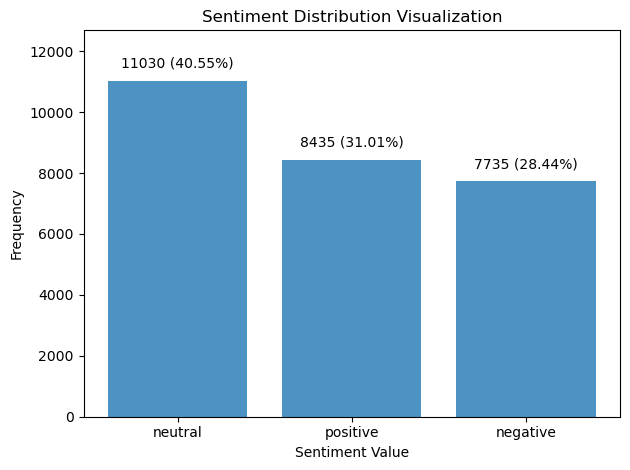

In [54]:
import matplotlib.pyplot as plt

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = df['sentiment'].value_counts()
sentiment_ratio = df['sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

SVM Implementation

In [68]:
def compute_specificity_and_fpr(confusion_matrix):
    """
    Compute specificity, false positive rate (FPR), weighted average, and macro average for a multi-class confusion matrix.
    
    Parameters:
    - confusion_matrix (numpy.ndarray): A square 2D numpy array representing the confusion matrix. Rows represent the true labels and columns represent predicted labels.
    
    Returns:
    - specificities (list): A list containing the specificity for each class.
    - fprs (list): A list containing the false positive rate for each class.
    - weighted_avg_spec (float): The weighted average specificity across all classes.
    - weighted_avg_fpr (float): The weighted average false positive rate across all classes.
    - macro_avg_spec (float): The macro average specificity across all classes.
    - macro_avg_fpr (float): The macro average false positive rate across all classes.
    """    
    num_classes = confusion_matrix.shape[0]
    specificities = []
    fprs = []
    
    true_values = np.sum(confusion_matrix, axis=1)
    total_true_values = np.sum(true_values)
    
    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        tn = sum(confusion_matrix[j, j] for j in range(num_classes) if j != i)
        fp = sum(confusion_matrix[j, i] for j in range(num_classes) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        
        specificities.append(specificity)
        fprs.append(fpr)
    
    weighted_avg_spec = sum(specificities[i] * true_values[i] for i in range(num_classes)) / total_true_values
    weighted_avg_fpr = sum(fprs[i] * true_values[i] for i in range(num_classes)) / total_true_values
    
    macro_avg_spec = sum(specificities) / num_classes
    macro_avg_fpr = sum(fprs) / num_classes

    return specificities, fprs, weighted_avg_spec, weighted_avg_fpr, macro_avg_spec, macro_avg_fpr


In [71]:
def plt_confusion_matrix(true_labels, predicted_labels, set_name="Data"):
    """
    Plots a confusion matrix using seaborn and displays metrics

    Parameters:
    - true_labels (list or array): Actual labels of the data.
    - predicted_labels (list or array): Predicted labels from a model.
    - set_name (str, optional): A string name for the data set. Default is "Data".

    Returns:
    None. Displays the confusion matrix plot.
    
    Note:
    The function assumes three classes: 'positive', 'negative', and 'neutral' and has them hardcoded for ordering.
    """
    order_map = {0: 'positive', 1: 'negative', 2: 'neutral'}
    unique_numeric_labels = sorted(list(set(true_labels)))
    unique_string_labels = [order_map[label] for label in unique_numeric_labels]
    
    cm = confusion_matrix(true_labels, predicted_labels, labels=unique_numeric_labels)
    specificities, fprs, weighted_avg_spec, weighted_avg_fpr, macro_avg_spec, macro_avg_fpr  = compute_specificity_and_fpr(cm)
    
    print("\nSpecificity per class:")
    for i, label in enumerate(unique_string_labels):
        print(f"{label}: {specificities[i]:.4f}")
        
    print("\nFalse Positive Rate (FPR) per class:")
    for i, label in enumerate(unique_string_labels):
        print(f"{label}: {fprs[i]:.4f}")
    
    print(f"\nWeighted average specificity: {weighted_avg_spec:.4f}")
    print(f"Weighted average FPR: {weighted_avg_fpr:.4f}")
    print(f"\nMacro average specificity: {macro_avg_spec:.4f}")
    print(f"Macro average FPR: {macro_avg_fpr:.4f}")
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{set_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [59]:
def display_sentences(X, y_true, y_pred, num_samples=5):
    """
    Print a number of misclassified samples.

    Parameters:
    - X: The original text data (e.g., sentences).
    - y_true: True labels.
    - y_pred: Predicted labels by the model.
    - num_samples: Number of misclassified samples to print for each category.

    Returns:
    None. Prints the misclassified samples.
    """
    misclassified_indices = np.where(y_true != y_pred)[0]
    order_map = {0: 'positive', 1: 'negative', 2: 'neutral'}

    for label_num, label_str in order_map.items():
        print(f"Misclassified as {label_str}:\n")
        count = 0
        for index in misclassified_indices:
            if y_pred[index] == label_num:
                print(f"True: {order_map[y_true[index]]}, Predicted: {label_str}, Text: {X.iloc[index]}")
                count += 1
                if count == num_samples:
                    break
        print("\n")

In [60]:
def train_svm_with_gridsearch(kernel_type, X_train_vec, y_train, X_val_vec, y_val, X_test_original ,X_test_vec, y_test):
    """
    Train and evaluate an SVM model with the given kernel type using GridSearchCV for hyperparameter tuning.
    
    Parameters:
    - kernel_type (str): The kernel type for the SVM. It can be 'linear', 'rbf', or 'poly'.
    - X_train_vec, y_train: Training data and their corresponding labels.
    - X_val_vec, y_val: Validation data and their corresponding labels.
    - X_test_vec, y_test: Test data and their corresponding labels.
    
    Returns:
    None. The function will print classification reports for training, validation, and test datasets.
    """
    
    parameters = {
          'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    }

    # Only adding 'gamma' for 'rbf' and 'poly' kernels
    if kernel_type in ['rbf', 'poly']:
        parameters['gamma'] = ['scale', 'auto']
    
    # SVM with GridSearchCV
    svm = SVC(kernel=kernel_type)
    clf = GridSearchCV(svm, parameters, cv=5)  # 5-fold cross-validation
    clf.fit(X_train_vec, y_train)

    # Use best estimator from GridSearchCV to make predictions
    y_train_pred = clf.best_estimator_.predict(X_train_vec)
    y_val_pred = clf.best_estimator_.predict(X_val_vec)
    y_test_pred = clf.best_estimator_.predict(X_test_vec)

    # Evaluating the model
    print(f"SVM Model with {kernel_type} kernel (Best Parameters: {clf.best_params_}):")
    print("\nTraining Metrics:")
    print(classification_report(y_train, y_train_pred, digits= 4))

    print("\nValidation Metrics:")
    print(classification_report(y_val, y_val_pred, digits= 4))
    plt_confusion_matrix(y_val, y_val_pred, "Validation")

    print("\nTest Metrics:")
    print(classification_report(y_test, y_test_pred, digits= 4))
    plt_confusion_matrix(y_test, y_test_pred, "Test")
    
    print("\nMisclassified Samples (Test Set):\n")
    display_sentences(X_test_original, y_test, y_test_pred)


In [61]:
def split_data(X, y):
    """
    Splits the dataset into training, validation, and test sets.

    Parameters:
    - X: Features.
    - y: Targets/Labels.

    Returns:
    - X_train, X_val, X_test: Training, validation, and test sets for features.
    - y_train, y_val, y_test: Training, validation, and test sets for targets/labels.
    """
    
    # splitting the dataset
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)
    
    # Resetting the indices
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [62]:
def vectorize_data(X_train, X_val, X_test, max_features, ngram_range, min_df, max_df):
    """
    Vectorizes the text data using TF-IDF.

    Parameters:
    - X_train, X_val, X_test: Training, validation, and test sets for features.
    - max_features: The maximum number of features (vocabulary size).
    - ngram_range: The range of n-gram.
    - min_df: Minimum document frequency.
    - max_df: Maximum document frequency.

    Returns:
    - X_train_vec, X_val_vec, X_test_vec: Vectorized training, validation, and test data.
    """
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features, ngram_range=ngram_range, min_df=min_df, max_df=max_df)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_val_vec, X_test_vec

In [63]:
#!pip install wget

In [64]:
'''import wget
import zipfile

# Downloading the GloVe embeddings
url = "http://nlp.stanford.edu/data/glove.6B.zip"
wget.download(url, "glove.6B.zip")

# Unzipping the downloaded file
with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
'''

'import wget\nimport zipfile\n\n# Downloading the GloVe embeddings\nurl = "http://nlp.stanford.edu/data/glove.6B.zip"\nwget.download(url, "glove.6B.zip")\n\n# Unzipping the downloaded file\nwith zipfile.ZipFile("glove.6B.zip", \'r\') as zip_ref:\n    zip_ref.extractall(".")\n'

In [65]:
def load_glove_model(glove_input_file, word2vec_output_file):
    """
    Convert GloVe embeddings to word2vec format and load them using gensim.
    
    Parameters:
    - glove_input_file (str): Path to the input GloVe embeddings.
    - word2vec_output_file (str): Path to the converted word2vec formatted file.

    Returns:
    - gensim.models.KeyedVectors: Loaded word2vec formatted embeddings.
    """
    
    # Convert GloVe file to word2vec format
    glove2word2vec(glove_input_file, word2vec_output_file)
    
    # Load the word2vec format file using gensim
    return gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

def vectorize_with_glove(X, glove_model):
    """
    Convert a list of text sentences into their averaged GloVe vector representations.

    Parameters:
    - X (list of str): List of text sentences.
    - glove_model (gensim.models.KeyedVectors): Loaded GloVe model using gensim.

    Returns:
    - np.array: An array of averaged GloVe vectors representing the input text.
    """
    
    embedding_matrix = []
    for text in X:
        words = [word for word in text.split() if word in glove_model]
        
        # Check if we have any valid words in the sentence
        if words:
            vector = np.mean([glove_model[word] for word in words], axis=0)
        else:
            vector = np.zeros(glove_model.vector_size) # If no words from the text are in GloVe
        
        # Check for NaN values
        if np.isnan(vector).any():
            vector = np.zeros(glove_model.vector_size)

        embedding_matrix.append(vector)
        
    return np.array(embedding_matrix)

glove_file = "glove.twitter.27B.50d.txt"
word2vec_output_file = "glove.twitter.27B.50d.txt.word2vec"

# Load the GloVe model into memory
glove_model = load_glove_model(glove_file, word2vec_output_file)

/var/folders/_4/gqsgcp1j0kx8p_ctzh3ddsmm0000gn/T/ipykernel_15793/197158687.py:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [66]:
# --- Data Preparation ---

# Map the sentiments to numerical values
target_map = {'neutral':2,'positive':0,'negative':1}
df = df.copy()
df.loc[:, 'target'] = df['sentiment'].map(target_map)
df.head()

,sentiment,cleaned_tweets,target
0,neutral,i would have responded if i were going,2
1,negative,sooo sad i will miss you here in san diego,1
2,negative,my boss is bullying me,1
3,negative,what interview leave me alone,1
4,negative,sons of why could not they put them on the r...,1


1000
SVM Model with linear kernel (Best Parameters: {'C': 1}):

Training Metrics:
              precision    recall  f1-score   support

           0     0.7294    0.5683    0.6389      5916
           1     0.7218    0.2380    0.3580      5394
           2     0.5137    0.8408    0.6377      7730

    accuracy                         0.5853     19040
   macro avg     0.6550    0.5490    0.5449     19040
weighted avg     0.6397    0.5853    0.5588     19040


Validation Metrics:
              precision    recall  f1-score   support

           0     0.7434    0.5614    0.6397      1254
           1     0.6951    0.2345    0.3507      1147
           2     0.5171    0.8457    0.6418      1679

    accuracy                         0.5865      4080
   macro avg     0.6519    0.5472    0.5441      4080
weighted avg     0.6367    0.5865    0.5593      4080


Specificity per class:
positive: 0.8742
negative: 0.9474
neutral: 0.4232

False Positive Rate (FPR) per class:
positive: 0.1258
negati

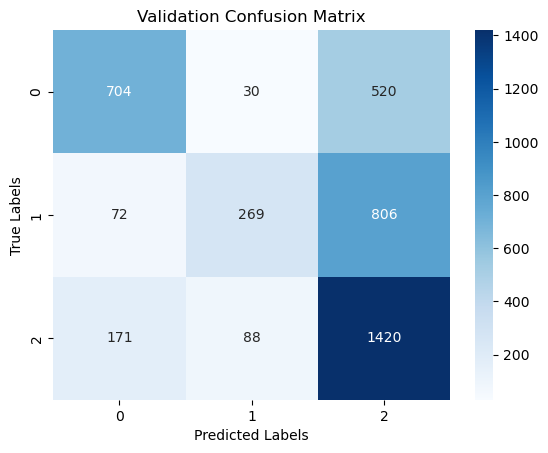


Test Metrics:
              precision    recall  f1-score   support

           0     0.7336    0.5660    0.6390      1265
           1     0.7612    0.2429    0.3683      1194
           2     0.5053    0.8489    0.6335      1621

    accuracy                         0.5838      4080
   macro avg     0.6667    0.5526    0.5469      4080
weighted avg     0.6510    0.5838    0.5576      4080


Specificity per class:
positive: 0.8650
negative: 0.9583
neutral: 0.4275

False Positive Rate (FPR) per class:
positive: 0.1350
negative: 0.0417
neutral: 0.5725

Weighted average specificity: 0.7185
Weighted average FPR: 0.2815

Macro average specificity: 0.7503
Macro average FPR: 0.2497


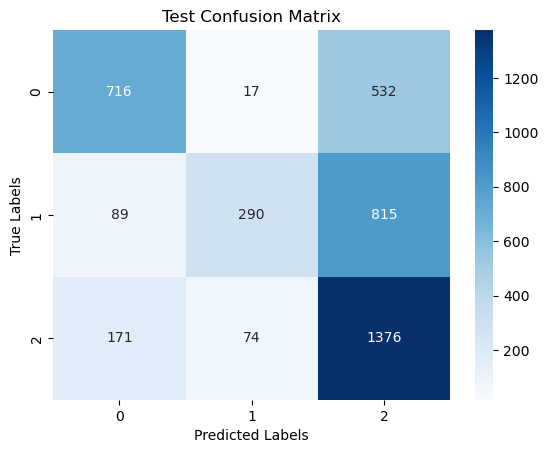


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text: wrong  your the only one i love they really have several women  


Misclassified as negative:

True: neutral, Predicted: negative, Text: _haze aww im sorry that ray wise has appeared on the show yet    i watch  everyday except for friday its a best of aots
True: neutral, Predicted: negative, Text: im moving to canada
True: neutral, Predicted: negative, Text:  no strange each time we return i feel like i have come home and yet i have no spanish blood tha

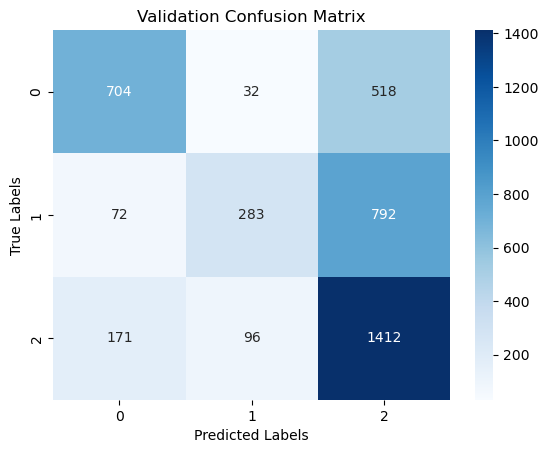


Test Metrics:
              precision    recall  f1-score   support

           0     0.7339    0.5692    0.6411      1265
           1     0.7488    0.2546    0.3800      1194
           2     0.5076    0.8433    0.6338      1621

    accuracy                         0.5860      4080
   macro avg     0.6634    0.5557    0.5516      4080
weighted avg     0.6484    0.5860    0.5618      4080


Specificity per class:
positive: 0.8649
negative: 0.9534
neutral: 0.4357

False Positive Rate (FPR) per class:
positive: 0.1351
negative: 0.0466
neutral: 0.5643

Weighted average specificity: 0.7203
Weighted average FPR: 0.2797

Macro average specificity: 0.7514
Macro average FPR: 0.2486


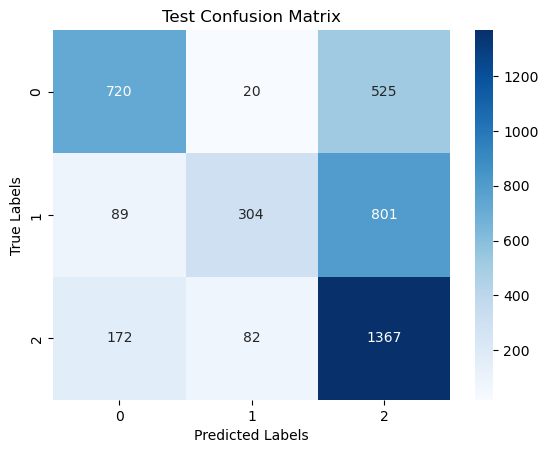


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text: wrong  your the only one i love they really have several women  


Misclassified as negative:

True: neutral, Predicted: negative, Text: _haze aww im sorry that ray wise has appeared on the show yet    i watch  everyday except for friday its a best of aots
True: neutral, Predicted: negative, Text: im moving to canada
True: neutral, Predicted: negative, Text:  no strange each time we return i feel like i have come home and yet i have no spanish blood tha

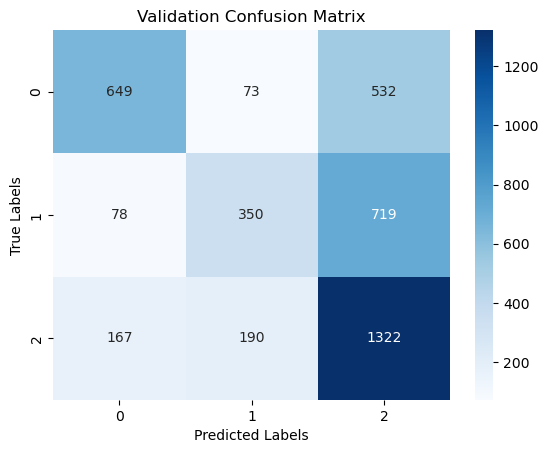


Test Metrics:
              precision    recall  f1-score   support

           0     0.7121    0.5123    0.5959      1265
           1     0.5942    0.3065    0.4044      1194
           2     0.4988    0.7859    0.6103      1621

    accuracy                         0.5608      4080
   macro avg     0.6017    0.5349    0.5369      4080
weighted avg     0.5928    0.5608    0.5456      4080


Specificity per class:
positive: 0.8623
negative: 0.8849
neutral: 0.4420

False Positive Rate (FPR) per class:
positive: 0.1377
negative: 0.1151
neutral: 0.5580

Weighted average specificity: 0.7019
Weighted average FPR: 0.2981

Macro average specificity: 0.7297
Macro average FPR: 0.2703


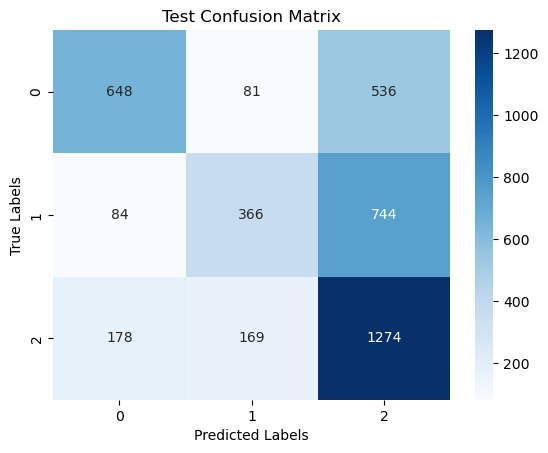


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text: wrong  your the only one i love they really have several women  


Misclassified as negative:

True: neutral, Predicted: negative, Text:   we drank ours away may day bank holiday today
True: positive, Predicted: negative, Text: juz donated booksmags  charity not only do i feel good but it gave me a good workout from all that heavy lifting
True: neutral, Predicted: negative, Text: oh and i am obviously back on my stupid sleep schedule luckily church is n

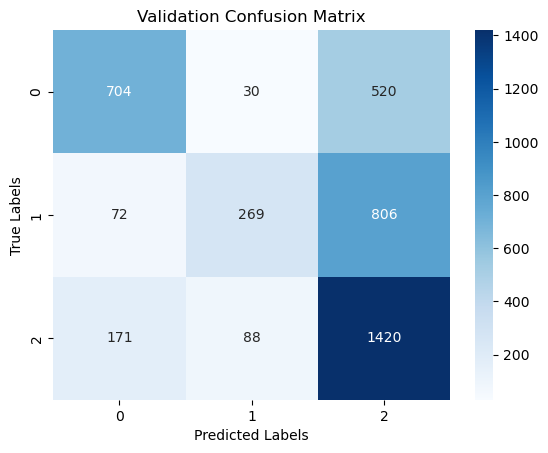


Test Metrics:
              precision    recall  f1-score   support

           0     0.7336    0.5660    0.6390      1265
           1     0.7612    0.2429    0.3683      1194
           2     0.5053    0.8489    0.6335      1621

    accuracy                         0.5838      4080
   macro avg     0.6667    0.5526    0.5469      4080
weighted avg     0.6510    0.5838    0.5576      4080


Specificity per class:
positive: 0.8650
negative: 0.9583
neutral: 0.4275

False Positive Rate (FPR) per class:
positive: 0.1350
negative: 0.0417
neutral: 0.5725

Weighted average specificity: 0.7185
Weighted average FPR: 0.2815

Macro average specificity: 0.7503
Macro average FPR: 0.2497


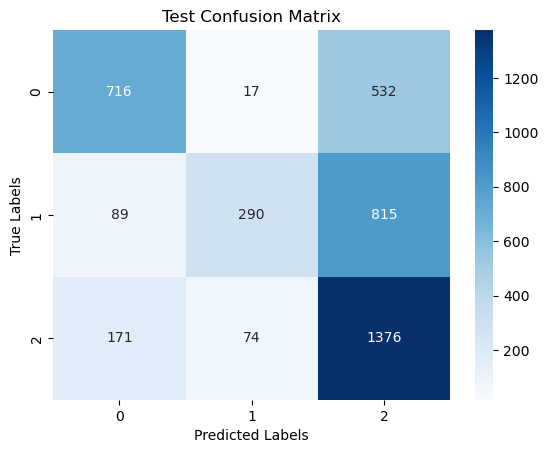


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text: wrong  your the only one i love they really have several women  


Misclassified as negative:

True: neutral, Predicted: negative, Text: _haze aww im sorry that ray wise has appeared on the show yet    i watch  everyday except for friday its a best of aots
True: neutral, Predicted: negative, Text: im moving to canada
True: neutral, Predicted: negative, Text:  no strange each time we return i feel like i have come home and yet i have no spanish blood tha

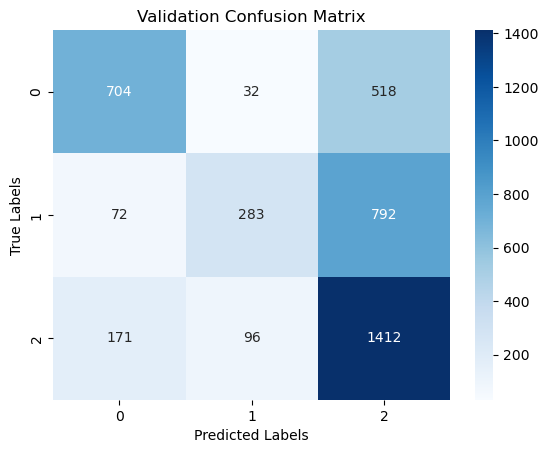


Test Metrics:
              precision    recall  f1-score   support

           0     0.7339    0.5692    0.6411      1265
           1     0.7488    0.2546    0.3800      1194
           2     0.5076    0.8433    0.6338      1621

    accuracy                         0.5860      4080
   macro avg     0.6634    0.5557    0.5516      4080
weighted avg     0.6484    0.5860    0.5618      4080


Specificity per class:
positive: 0.8649
negative: 0.9534
neutral: 0.4357

False Positive Rate (FPR) per class:
positive: 0.1351
negative: 0.0466
neutral: 0.5643

Weighted average specificity: 0.7203
Weighted average FPR: 0.2797

Macro average specificity: 0.7514
Macro average FPR: 0.2486


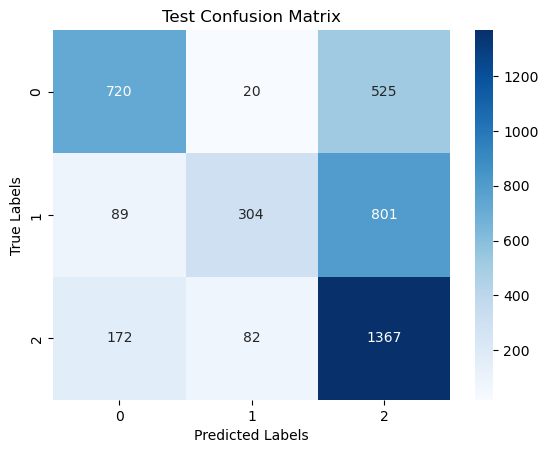


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text: wrong  your the only one i love they really have several women  


Misclassified as negative:

True: neutral, Predicted: negative, Text: _haze aww im sorry that ray wise has appeared on the show yet    i watch  everyday except for friday its a best of aots
True: neutral, Predicted: negative, Text: im moving to canada
True: neutral, Predicted: negative, Text:  no strange each time we return i feel like i have come home and yet i have no spanish blood tha

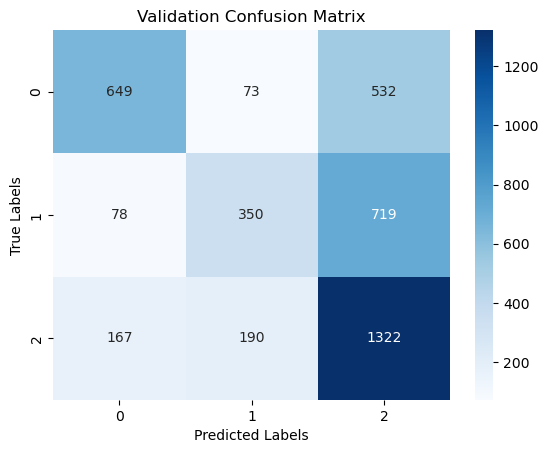


Test Metrics:
              precision    recall  f1-score   support

           0     0.7121    0.5123    0.5959      1265
           1     0.5942    0.3065    0.4044      1194
           2     0.4988    0.7859    0.6103      1621

    accuracy                         0.5608      4080
   macro avg     0.6017    0.5349    0.5369      4080
weighted avg     0.5928    0.5608    0.5456      4080


Specificity per class:
positive: 0.8623
negative: 0.8849
neutral: 0.4420

False Positive Rate (FPR) per class:
positive: 0.1377
negative: 0.1151
neutral: 0.5580

Weighted average specificity: 0.7019
Weighted average FPR: 0.2981

Macro average specificity: 0.7297
Macro average FPR: 0.2703


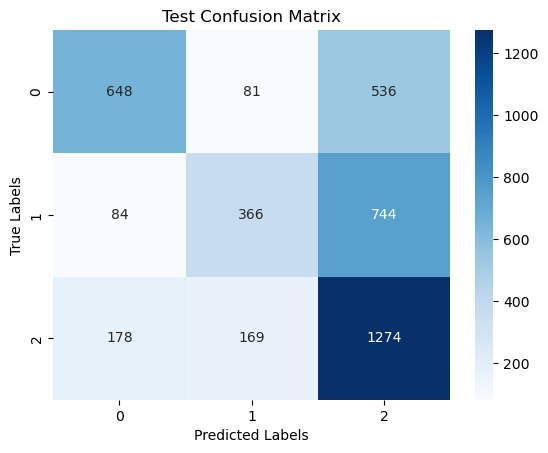


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text: wrong  your the only one i love they really have several women  


Misclassified as negative:

True: neutral, Predicted: negative, Text:   we drank ours away may day bank holiday today
True: positive, Predicted: negative, Text: juz donated booksmags  charity not only do i feel good but it gave me a good workout from all that heavy lifting
True: neutral, Predicted: negative, Text: oh and i am obviously back on my stupid sleep schedule luckily church is n

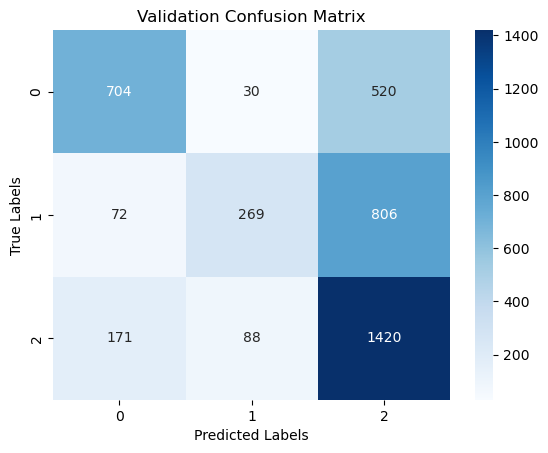


Test Metrics:
              precision    recall  f1-score   support

           0     0.7336    0.5660    0.6390      1265
           1     0.7612    0.2429    0.3683      1194
           2     0.5053    0.8489    0.6335      1621

    accuracy                         0.5838      4080
   macro avg     0.6667    0.5526    0.5469      4080
weighted avg     0.6510    0.5838    0.5576      4080


Specificity per class:
positive: 0.8650
negative: 0.9583
neutral: 0.4275

False Positive Rate (FPR) per class:
positive: 0.1350
negative: 0.0417
neutral: 0.5725

Weighted average specificity: 0.7185
Weighted average FPR: 0.2815

Macro average specificity: 0.7503
Macro average FPR: 0.2497


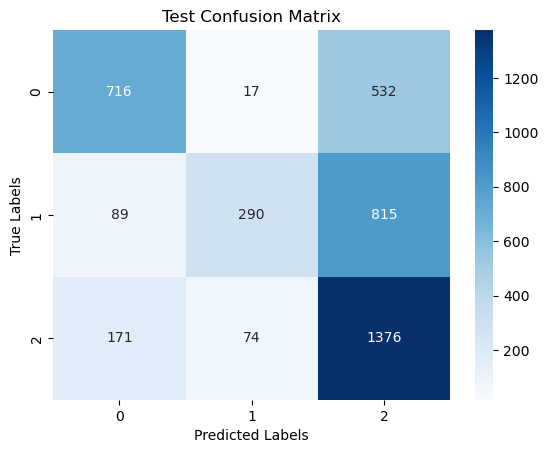


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text: wrong  your the only one i love they really have several women  


Misclassified as negative:

True: neutral, Predicted: negative, Text: _haze aww im sorry that ray wise has appeared on the show yet    i watch  everyday except for friday its a best of aots
True: neutral, Predicted: negative, Text: im moving to canada
True: neutral, Predicted: negative, Text:  no strange each time we return i feel like i have come home and yet i have no spanish blood tha

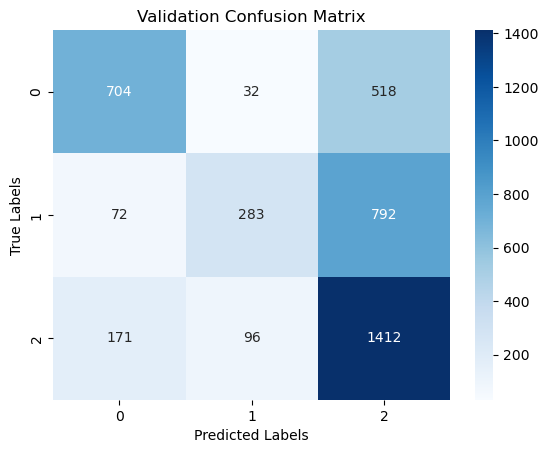


Test Metrics:
              precision    recall  f1-score   support

           0     0.7339    0.5692    0.6411      1265
           1     0.7488    0.2546    0.3800      1194
           2     0.5076    0.8433    0.6338      1621

    accuracy                         0.5860      4080
   macro avg     0.6634    0.5557    0.5516      4080
weighted avg     0.6484    0.5860    0.5618      4080


Specificity per class:
positive: 0.8649
negative: 0.9534
neutral: 0.4357

False Positive Rate (FPR) per class:
positive: 0.1351
negative: 0.0466
neutral: 0.5643

Weighted average specificity: 0.7203
Weighted average FPR: 0.2797

Macro average specificity: 0.7514
Macro average FPR: 0.2486


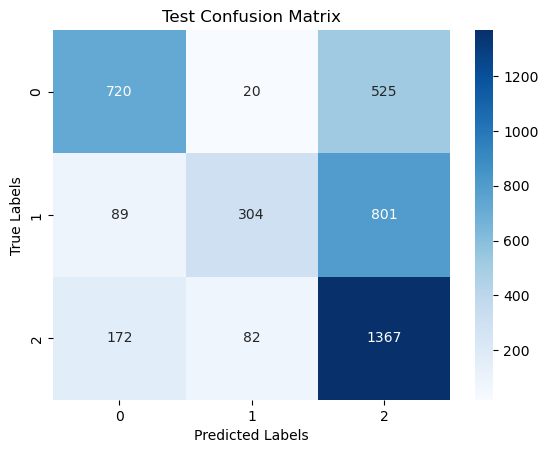


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text: wrong  your the only one i love they really have several women  


Misclassified as negative:

True: neutral, Predicted: negative, Text: _haze aww im sorry that ray wise has appeared on the show yet    i watch  everyday except for friday its a best of aots
True: neutral, Predicted: negative, Text: im moving to canada
True: neutral, Predicted: negative, Text:  no strange each time we return i feel like i have come home and yet i have no spanish blood tha

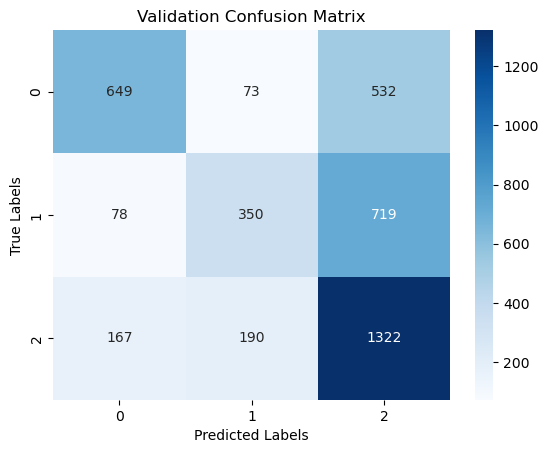


Test Metrics:
              precision    recall  f1-score   support

           0     0.7121    0.5123    0.5959      1265
           1     0.5942    0.3065    0.4044      1194
           2     0.4988    0.7859    0.6103      1621

    accuracy                         0.5608      4080
   macro avg     0.6017    0.5349    0.5369      4080
weighted avg     0.5928    0.5608    0.5456      4080


Specificity per class:
positive: 0.8623
negative: 0.8849
neutral: 0.4420

False Positive Rate (FPR) per class:
positive: 0.1377
negative: 0.1151
neutral: 0.5580

Weighted average specificity: 0.7019
Weighted average FPR: 0.2981

Macro average specificity: 0.7297
Macro average FPR: 0.2703


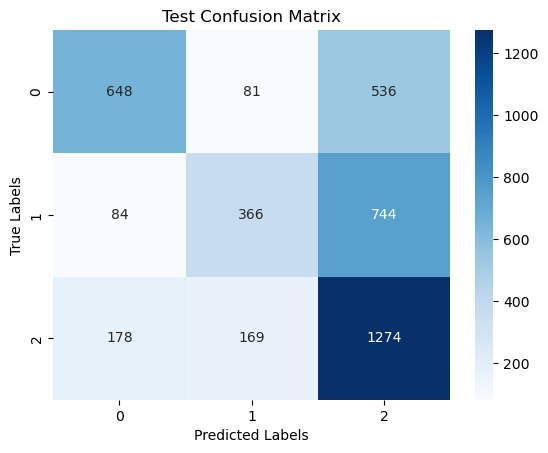


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text: wrong  your the only one i love they really have several women  


Misclassified as negative:

True: neutral, Predicted: negative, Text:   we drank ours away may day bank holiday today
True: positive, Predicted: negative, Text: juz donated booksmags  charity not only do i feel good but it gave me a good workout from all that heavy lifting
True: neutral, Predicted: negative, Text: oh and i am obviously back on my stupid sleep schedule luckily church is n

In [72]:
# Main Execution
X = df['cleaned_tweets']
y = df['target']
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

#TFIDF Vectorizing
max_features_list = [1000, 5000, 10000]
kernels = ['linear', 'rbf', 'poly']

for max_features in max_features_list:
    print(max_features)
    X_train_vec, X_val_vec, X_test_vec = vectorize_data(X_train, X_val, X_test, max_features=max_features, ngram_range=(1,3), min_df=0.01, max_df=0.90)
    for kernel in kernels:
        train_svm_with_gridsearch(kernel, X_train_vec, y_train, X_val_vec, y_val, X_test, X_test_vec, y_test)


SVM Model with linear kernel (Best Parameters: {'C': 10}):

Training Metrics:
              precision    recall  f1-score   support

           0     0.7016    0.5747    0.6319      5916
           1     0.6558    0.4461    0.5310      5394
           2     0.5400    0.7353    0.6227      7730

    accuracy                         0.6035     19040
   macro avg     0.6325    0.5854    0.5952     19040
weighted avg     0.6230    0.6035    0.5996     19040


Validation Metrics:
              precision    recall  f1-score   support

           0     0.6787    0.5678    0.6183      1254
           1     0.6466    0.4307    0.5170      1147
           2     0.5421    0.7320    0.6229      1679

    accuracy                         0.5968      4080
   macro avg     0.6225    0.5768    0.5861      4080
weighted avg     0.6135    0.5968    0.5917      4080


Specificity per class:
positive: 0.8364
negative: 0.8779
neutral: 0.5374

False Positive Rate (FPR) per class:
positive: 0.1636
negative: 

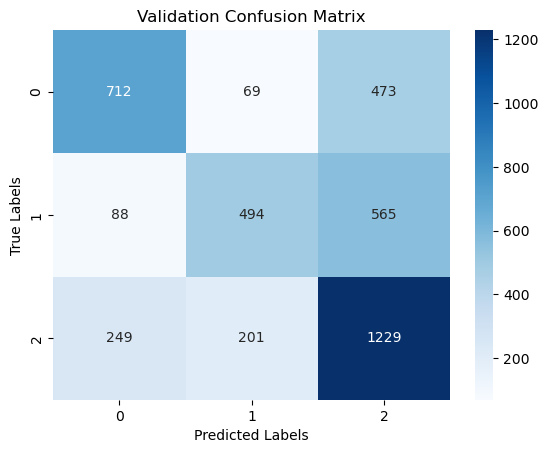


Test Metrics:
              precision    recall  f1-score   support

           0     0.7014    0.5960    0.6444      1265
           1     0.6763    0.4305    0.5261      1194
           2     0.5332    0.7384    0.6192      1621

    accuracy                         0.6042      4080
   macro avg     0.6370    0.5883    0.5966      4080
weighted avg     0.6272    0.6042    0.5998      4080


Specificity per class:
positive: 0.8420
negative: 0.8880
neutral: 0.5475

False Positive Rate (FPR) per class:
positive: 0.1580
negative: 0.1120
neutral: 0.4525

Weighted average specificity: 0.7385
Weighted average FPR: 0.2615

Macro average specificity: 0.7592
Macro average FPR: 0.2408


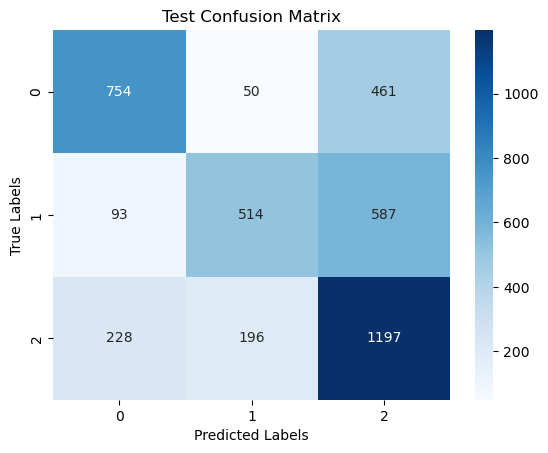


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: ian is waiting for a very important pic
True: negative, Predicted: positive, Text: yea baby im going to miss you so much


Misclassified as negative:

True: neutral, Predicted: negative, Text: _baby  your not talking about your obsession with me right
True: neutral, Predicted: negative, Text: oh and i am obviously back on my stupid sleep schedule luckily church is not until  tomorrow
True: neutral, Predicted: negative, Text: its a beautiful day outside today shame i am stuck in the office with the blinds shut to stop glare
True: neutral, Predicted: negative, Text: its about to 

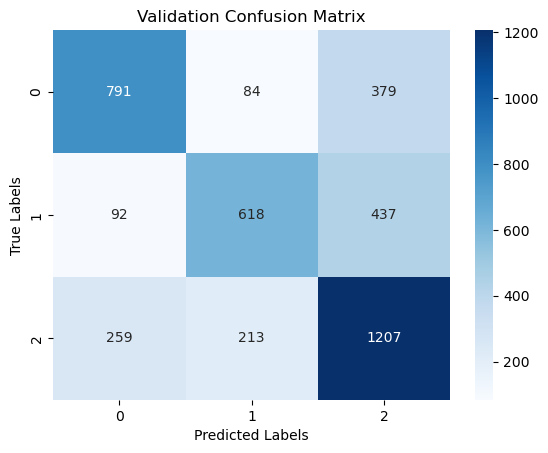


Test Metrics:
              precision    recall  f1-score   support

           0     0.7089    0.6545    0.6806      1265
           1     0.6810    0.5310    0.5967      1194
           2     0.5866    0.7168    0.6452      1621

    accuracy                         0.6431      4080
   macro avg     0.6588    0.6341    0.6408      4080
weighted avg     0.6521    0.6431    0.6420      4080


Specificity per class:
positive: 0.8408
negative: 0.8701
neutral: 0.6409

False Positive Rate (FPR) per class:
positive: 0.1592
negative: 0.1299
neutral: 0.3591

Weighted average specificity: 0.7700
Weighted average FPR: 0.2300

Macro average specificity: 0.7840
Macro average FPR: 0.2160


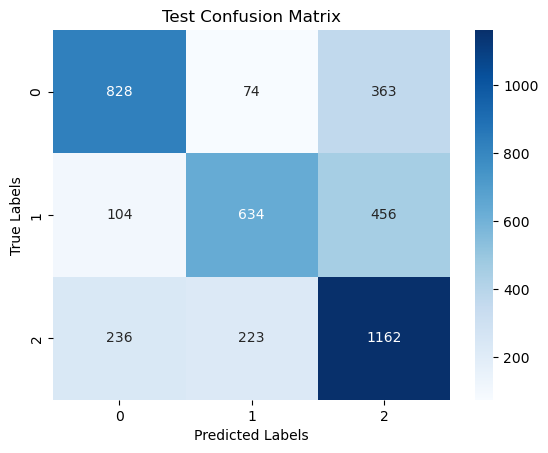


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text:  ahhh lincolnill runsee you in  hours
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you


Misclassified as negative:

True: positive, Predicted: negative, Text: _ haaa awesome i remember my brother got given woody and i got upset cause i got buzz  but then i got both of them lmfao
True: neutral, Predicted: negative, Text: _baby  your not talking about your obsession with me right
True: neutral, Predicted: negative, Text: oh and i am obviously back on my stupid sleep schedule luckily church is not until 

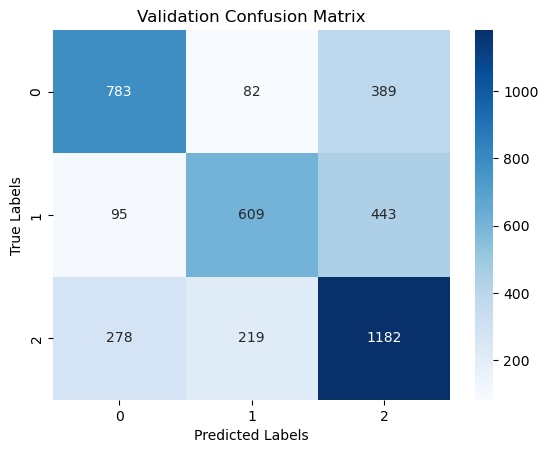


Test Metrics:
              precision    recall  f1-score   support

           0     0.7025    0.6403    0.6700      1265
           1     0.6763    0.5302    0.5944      1194
           2     0.5766    0.7082    0.6357      1621

    accuracy                         0.6350      4080
   macro avg     0.6518    0.6262    0.6333      4080
weighted avg     0.6448    0.6350    0.6342      4080


Specificity per class:
positive: 0.8385
negative: 0.8660
neutral: 0.6312

False Positive Rate (FPR) per class:
positive: 0.1615
negative: 0.1340
neutral: 0.3688

Weighted average specificity: 0.7642
Weighted average FPR: 0.2358

Macro average specificity: 0.7786
Macro average FPR: 0.2214


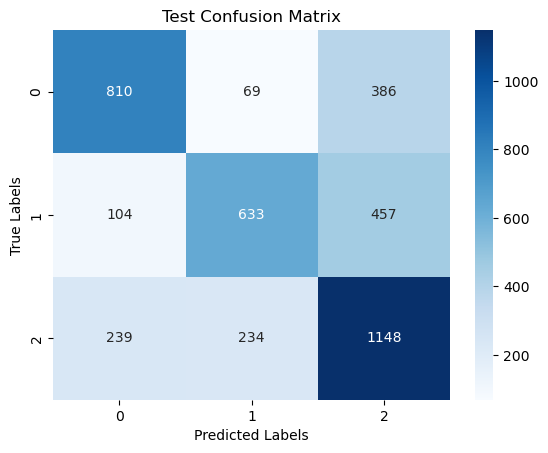


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: how i wish the result is true
True: negative, Predicted: positive, Text: back at the vet and it is not good
True: neutral, Predicted: positive, Text:  umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
True: neutral, Predicted: positive, Text: apparently today is happy star wars day  i am suppose to say may the th be with you
True: negative, Predicted: positive, Text:  um that is really scary please be safe  btw ill be in orlando next week


Misclassified as negative:

True: positive, Predicted: negative, Text: _ haaa awesome i remember my brother got given woody and i got upset cause i got buzz  but then i got both of them lmfao
True: neutral, Predicted: negative, Text: _baby  your not talking about your obsession with me right
True: neutral, Predicted: negative, Text: oh and i am obviously back on my stupid sleep s

In [73]:
# Vectorize using GloVe embeddings
X_train_vec_glove = vectorize_with_glove(X_train, glove_model)
X_val_vec_glove = vectorize_with_glove(X_val, glove_model)
X_test_vec_glove = vectorize_with_glove(X_test, glove_model)

kernels = ['linear', 'rbf', 'poly']

for kernel in kernels:
    train_svm_with_gridsearch(kernel, X_train_vec_glove, y_train, X_val_vec_glove, y_val, X_test, X_test_vec_glove, y_test)
